<a href="https://colab.research.google.com/github/Jesus-Vazquez-A/Insurence/blob/main/Selection_of_model_ideal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings # ignore warnings
import pandas as pd # data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

In [2]:
warnings.filterwarnings("ignore")

In [65]:
df=pd.read_csv("/content/insurence_clear")
df=df.drop(["Unnamed: 0"],axis="columns")

In [66]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,18,male,33.77,1,no,southeast,1725.5523
1,28,male,33.00,3,no,southeast,4449.4620
2,25,male,26.22,0,no,northeast,2721.3208
3,23,male,34.40,0,no,southwest,1826.8430
4,19,male,24.60,1,no,southwest,1837.2370


In [67]:
def dataset():
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=dataset()


# **Split data**

In [68]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               y,
                                               test_size=0.33,
                                               random_state=42)

### **Data preprocessing**

* **MinMaxScaler**  It consists of adjusting the data on a scale from 0 to 1. With the aim that the variables are comparable to each other. 

* **OneHotEncoding** It is used for qualitative variables. For example the geographical location or the color of a car.
It consists of creating several fictitious variables according to the number of categorical variables. Where a 1 is indicated if said observation belongs to the class. It's a similar thing with truth tables if you're familiar with programming.


* **PolynomialFeatures** It consists of raising to a certain power. To break the linearity of the data. Since sometimes a linear regression is not enough to solve the problem.

In [69]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,PolynomialFeatures 

In [70]:
poly=PolynomialFeatures(degree=2) # degree polynomial
rescale=MinMaxScaler()
def poly_transform(x):
    
    x=pd.get_dummies(x,drop_first=True) # dummy variables
    x[["age","bmi","children"]]=rescale.fit_transform(x[["age","bmi","children"]]) # reescale
    
    return poly.fit_transform(x) # polynomial transform

In [71]:
X_train_poly=poly_transform(X_train)
X_test_poly=poly_transform(X_test)

## **Creation of the polynomial model**

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
poly.fit(X_train_poly,Y_train) # we give the training data

PolynomialFeatures()

In [74]:
lm=LinearRegression()

In [75]:
lm.fit(X_train_poly,Y_train) #  we give the training data

LinearRegression()

In [76]:
lm.score(X_train_poly,Y_train) # evaluate with training data

0.9638277366641799

In [77]:
lm.score(X_test_poly,Y_test) # evaluate with testing data

0.9535453012796803

## **Data transform**

In [78]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [79]:
tf_colummns=make_column_transformer((MinMaxScaler(),["age","bmi","children"]), # Reescale
                                   (OneHotEncoder(drop="if_binary"),["region","sex","smoker"])) # OneHotEncoding

## *Mean square error*
Measures the average error between the original and predicted values.

In [80]:
from sklearn.metrics import mean_squared_error

# **Gradient Boosting**

It is an algorithm that uses such complex algorithms. That is perfected according to the learning rate assigned by the user. In such a way that each tree will become better than the previous one. And the predicted value is going to average the predictions of the weakest algorithms.

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]

    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=GradientBoostingRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42)
        model=Pipeline([("transform",tf_colummns),("model",model)])
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [83]:
def dataframe_evaluate_trees(max_depth,lr):
  
    n_trees,mse_test,mse_train=evaluate(max_depth=max_depth,lr=lr)

    df_evaluate=pd.DataFrame({"n_trees": n_trees,"mse_test":mse_test,"mse_train":mse_train}) 
  
    return df_evaluate

In [84]:
first_evaluete=dataframe_evaluate_trees(max_depth=2,lr=0.01)

In [85]:
second_evalue=dataframe_evaluate_trees(max_depth=3,lr=0.01)

### *Ideal number of estimators*

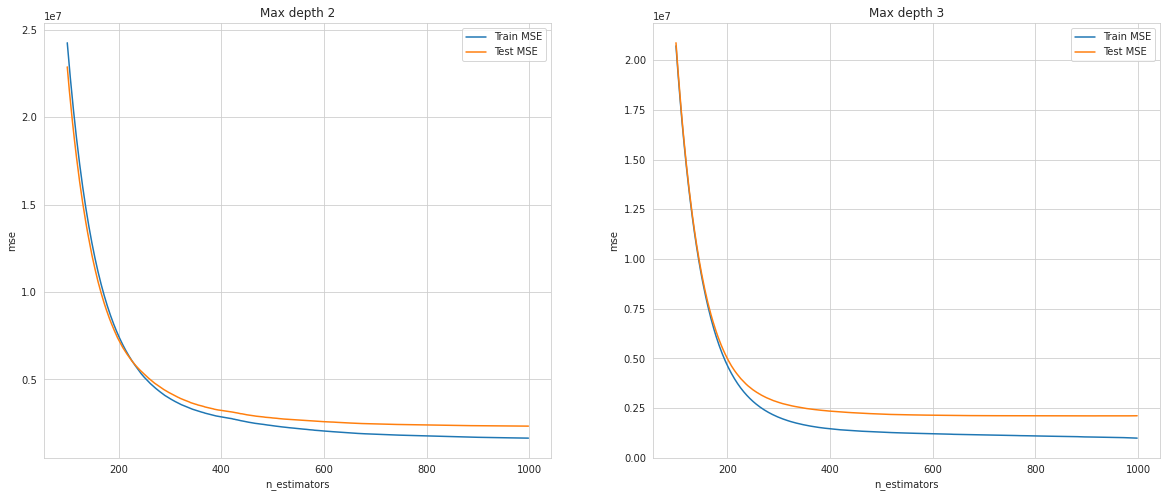

In [86]:
sns.set_style(style="whitegrid")
fig,(ax,ax_1)=plt.subplots(1,2,figsize=(20,8))

ax.set_title("Max depth 2")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_train"],label="Train MSE")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_test"],label="Test MSE")
ax.set_xlabel("n_estimators")
ax.set_ylabel("mse")
    
ax_1.set_title("Max depth 3")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_train"],label="Train MSE")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_test"],label="Test MSE")
ax_1.set_xlabel("n_estimators")
ax_1.set_ylabel("mse")
    

    
ax.legend()
ax_1.legend()


plt.show()

With a maximum depth of 2 there is less overfitting. The ideal number of estimators for this model ranges from **600** to **650**.

In [88]:
first_evaluete.query("n_trees>=610 and n_trees<=650")

,n_trees,mse_test,mse_train
255,610,2.565604e+06,2.022880e+06
256,612,2.563759e+06,2.019562e+06
257,614,2.560127e+06,2.012498e+06
258,616,2.559540e+06,2.009736e+06
259,618,2.556909e+06,2.006515e+06
260,620,2.551986e+06,2.001062e+06
261,622,2.550468e+06,1.998355e+06
262,624,2.545394e+06,1.991937e+06
263,626,2.541826e+06,1.989505e+06
264,628,2.539224e+06,1.983893e+06



Starting from the estimator number 614 there is no longer an improvement for the test data.

In [89]:
gbr=GradientBoostingRegressor(max_depth=2,
                          learning_rate=0.01,
                          n_estimators=620,
                          random_state=42)

In [90]:
gbr_pipeline=Pipeline([('preprocess',tf_colummns),
                       ('adaboost',gbr)])

In [91]:
gbr_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex',
                                                   'smoker'])])),
                ('adaboost',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=2,
                                           n_estimators=620,
                                           random_state=42))])

In [92]:
gbr_pipeline.score(X_train,Y_train) # evaluate with training data

0.9851745897833021

In [93]:
gbr_pipeline.score(X_test,Y_test) # evaluate with test data

0.981613309151634

# *XGBOOST*

It is similar to adaboost. With the difference that xgboost can be used with GPU. Which training will be faster.

In [94]:
from xgboost import XGBRegressor

## *Selection number of estimators XGBOOST*

In [95]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]
    
    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=XGBRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42,verbosity=0)
        model=Pipeline([("transform",tf_colummns),("model",model)])
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [96]:
first_evaluete=dataframe_evaluate_trees(max_depth=2,lr=0.01)

In [97]:
second_evaluete=dataframe_evaluate_trees(max_depth=3,lr=0.01)

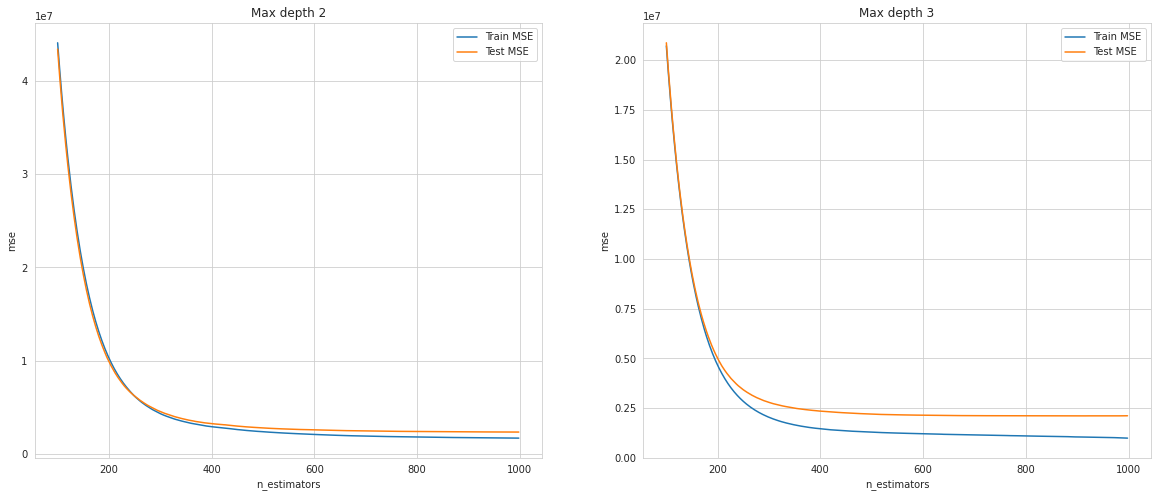

In [98]:
sns.set_style(style="whitegrid")
fig,(ax,ax_1)=plt.subplots(1,2,figsize=(20,8))

ax.set_title("Max depth 2")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_train"],label="Train MSE")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_test"],label="Test MSE")
ax.set_xlabel("n_estimators")
ax.set_ylabel("mse")
    
ax_1.set_title("Max depth 3")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_train"],label="Train MSE")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_test"],label="Test MSE")
ax_1.set_xlabel("n_estimators")
ax_1.set_ylabel("mse")
    

    
ax.legend()
ax_1.legend()


plt.show()


It happens in a similar way. With the difference that I can use more estimator without overfitting the model. The ideal range is between **600** to **650** estimators. Since from this amount, the error does not decrease drastically for the test data.

In [106]:
first_evaluete.query("n_trees>=600 and n_trees<=650")

,n_trees,mse_test,mse_train
250,600,2.586768e+06,2.093440e+06
251,602,2.585983e+06,2.090484e+06
252,604,2.584313e+06,2.084226e+06
253,606,2.581511e+06,2.081058e+06
254,608,2.575910e+06,2.075198e+06
255,610,2.573407e+06,2.072100e+06
256,612,2.571179e+06,2.067199e+06
257,614,2.566200e+06,2.060868e+06
258,616,2.562364e+06,2.058199e+06
259,618,2.560341e+06,2.055163e+06


We select 650. Since from ciho estimator there is no significant improvement.

In [116]:
xgb_reg=XGBRegressor(max_depth=2,
                     learning_rate=0.01,
                     n_estimators=650,
                     verbosity=0,
                     random_state=42)

xgb_pipeline=Pipeline([("transform",tf_colummns),("gbr",xgb_reg)])

In [117]:
xgb_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex',
                                                   'smoker'])])),
                ('gbr',
                 XGBRegressor(learning_rate=0.01, max_depth=2, n_estimators=650,
                              random_state=42, verbosity=0))])

In [118]:
xgb_pipeline.score(X_train,Y_train)

0.9852467167414591

In [119]:
xgb_pipeline.score(X_test,Y_test)

0.9818729241879265

In [120]:
def predict(model,x):
    
    return model.predict(x)

pred_poly_train=predict(lm,X_train_poly)
pred_poly_test=predict(lm,X_test_poly)

pred_gbr_train=predict(gbr_pipeline,X_train)
pred_gbr_test=predict(gbr_pipeline,X_test)

pred_xgb_train=predict(xgb_pipeline,X_train)
pred_xgb_test=predict(xgb_pipeline,X_test)      

In [121]:
def mse(y_true,y_pred):

    return mean_squared_error(y_true=y_true,y_pred=y_pred)

mse_poly_train=mse(Y_train,pred_poly_train)
mse_poly_test=mse(Y_test,pred_poly_test)

mse_gbr_train=mse(Y_train,pred_gbr_train)
mse_gbr_test=mse(Y_test,pred_gbr_test)

mse_xgb_train=mse(Y_train,pred_xgb_train)
mse_xgb_test=mse(Y_test,pred_xgb_test)  

### **Cross Validation**

In [124]:
from sklearn.model_selection import cross_val_score

In [125]:
def cv_score(model,x,y):
    
    return cross_val_score(model,x,y,cv=10).mean()

In [126]:
cv_poly=cv_score(lm,X_test_poly,Y_test)
cv_gbr=cv_score(gbr_pipeline,X_test,Y_test)
cv_xgb=cv_score(xgb_pipeline,X_test,Y_test)

### **Dataframe evaluation**

In [127]:
models_names=["Polynomial Regression","Gradient Boosting","XGBOOST"]
mse_train=[mse_poly_train,mse_gbr_train,mse_xgb_train]
mse_test=[mse_poly_test,mse_gbr_test,mse_xgb_test]

cv=[cv_poly,cv_gbr,cv_xgb]

evaluate_df=pd.DataFrame({"Model":models_names,
                          "MSE train":mse_train,
                          "MSE test":mse_test,"CV":cv})

In [128]:
evaluate_df

,Model,MSE train,MSE test,CV
0,Polynomial Regression,4.882356e+06,6.447692e+06,0.950892
1,Gradient Boosting,2.001062e+06,2.551986e+06,0.978268
2,XGBOOST,1.991326e+06,2.515952e+06,0.979193


**XGBOOST** has better performance metrics than the Polynomial model and Gradient Boosting

In [129]:


df_test=pd.DataFrame({"true_values":Y_test,
                        "pred_poly":pred_poly_test,
                      "pred_adaboost":pred_gbr_test,
                      "pred_xgb":pred_xgb_test,
                      "smoker":X_test["smoker"]
                     })

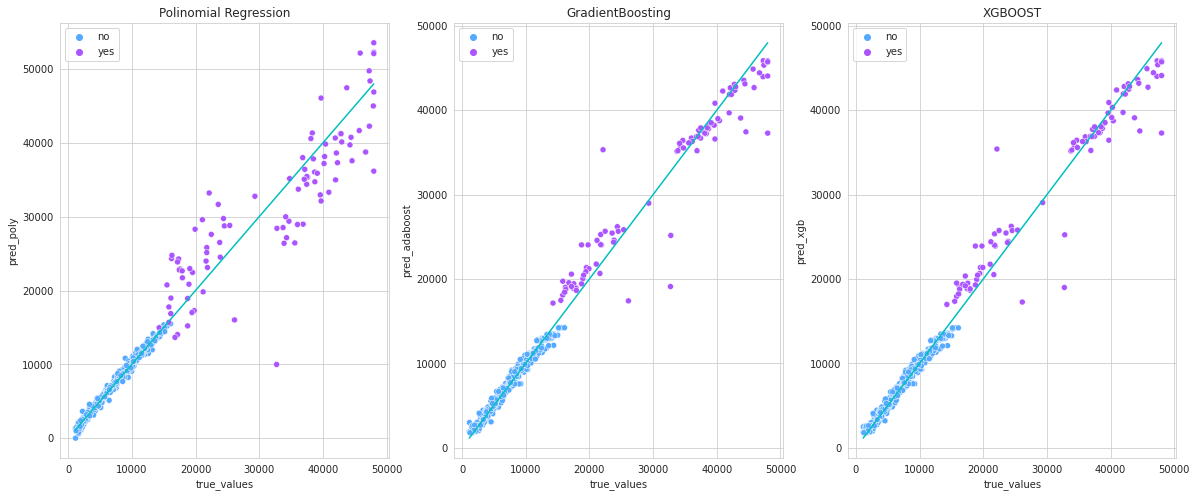

In [130]:
fig,(ax_0,ax_1,ax_2)=plt.subplots(1,3,figsize=(20,8))
sns.set_style(style="whitegrid")

ax_0.set_title("Polinomial Regression")
sns.scatterplot(data=df_test,x="true_values",y="pred_poly",color="red",hue="smoker",ax=ax_0,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_0)


ax_1.set_title("GradientBoosting")
sns.scatterplot(data=df_test,x="true_values",y="pred_adaboost",color="red",hue="smoker",ax=ax_1,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_1)

ax_2.set_title("XGBOOST")
sns.scatterplot(data=df_test,x="true_values",y="pred_xgb",color="red",hue="smoker",ax=ax_2,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_2)

plt.show()

## **Conclusion** 

* The **Polynomial Regression** is good to predict those users who do not smoke, for smokers it gives not so accurate predictions.

* **Gradient Boosting** It is good for both cases.

* **XGBOOST** Has a better root mean square error than using gradient boosting. In turn, it is faster to train and presents fewer symptoms of overfitting.